In [1]:
from pymongo import MongoClient
from rdkit import Chem
from rdkit.Chem import Draw

import pandas as pd

import matplotlib.pyplot as plt
import venn
%matplotlib inline

from math import *
import os
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Descriptors

import itertools
from collections import Counter

**Complete Databank**

In [2]:
client = MongoClient("localhost:27017")
db_complete = client['COCONUT2020-10']

In [3]:
collection = db_complete.uniqueNaturalProduct
db_complete_only_ring_sugars = pd.DataFrame(list(collection.find({"contains_ring_sugars": True})))

In [4]:
df_complete_tax = pd.DataFrame({"taxonomy": db_complete_only_ring_sugars["textTaxa"],
                       "smiles": db_complete_only_ring_sugars["smiles"],
                       "coconut_id": db_complete_only_ring_sugars["coconut_id"],
                       "no_sugar_smiles": db_complete_only_ring_sugars["sugar_free_smiles"]
                      })

In [5]:
#display(df_complete_tax)

In [6]:
complete_names = []
indexes = []
for i in range(len(df_complete_tax.taxonomy)):
    # some entries are empty lists
    # doubles
    if df_complete_tax.taxonomy[i] != [] and ("plants" in df_complete_tax.taxonomy[i] or "bacteria" in df_complete_tax.taxonomy[i] or "marine" in df_complete_tax.taxonomy[i] or "animals" in df_complete_tax.taxonomy[i] or "fungi" in df_complete_tax.taxonomy[i]):
        indexes.append(i)
        complete_names.append(df_complete_tax.taxonomy[i])
        
        
    

In [7]:
df_five_tax = df_complete_tax.loc[indexes[:]]

In [8]:
#df_five_tax

In [9]:
df_tax_id = pd.DataFrame({"taxonomy": df_five_tax.taxonomy,
                                   "coconut_id": df_five_tax.coconut_id})

In [10]:
taxonomies = ["plants","bacteria","fungi","marine","animals"]
biology_names = []
for row in df_tax_id.taxonomy:
    for name in row:
        if name not in taxonomies:
            biology_names.append(name)

In [11]:
for biology_name in biology_names:
    for row in df_tax_id.taxonomy:
        if biology_name in row:
            row.remove(biology_name)
            
            

In [12]:
taxonomy_Double = []
taxonomy_Triple = []
taxonomy_single_entry = []
for tax_list in df_tax_id.taxonomy:
    if len(tax_list) == 1:
        taxonomy_single_entry.append(tax_list[0])
    elif len(tax_list) == 2: 
        taxonomy_single_entry.append('double')
        # save original annotation
        taxonomyDouble1 = []
        for tax in tax_list:
            taxonomyDouble1.append(tax)
        taxonomy_Double.append(taxonomyDouble1)
    elif len(tax_list) == 3:
        taxonomy_single_entry.append('triple')
        # save original annotation
        taxonomyTriple1 = []
        for tax in tax_list:
            taxonomyTriple1.append(tax)
        taxonomy_Triple.append(taxonomyTriple1)

In [13]:
df_tax_id_fromCompleteDatabank = pd.DataFrame({"taxonomy": taxonomy_single_entry,
                     "coconut_id": df_five_tax.coconut_id})

**Sweetcoconut Databank**

In [14]:
client2 = MongoClient("localhost:27017")
db_s = client2["sweetcoconut"]
collection2 = db_s.sweetNaturalProduct
sweetnp = pd.DataFrame(list(collection2.find({"contains_sugar": True})))

In [15]:
sweetnp_with_tax = pd.merge(sweetnp, df_tax_id_fromCompleteDatabank, how="left", on="coconut_id")

In [16]:
df_cutout_sweetnp_with_tax = pd.DataFrame({"coconut_id": sweetnp_with_tax.coconut_id,
                             "taxonomy": sweetnp_with_tax.taxonomy,
                             "all_deglycosilated_smiles": sweetnp_with_tax.all_deglycosilated_smiles
})

In [17]:
df_cutout_no_nan = df_cutout_sweetnp_with_tax.fillna('no')

In [18]:
df_cutout_explode = df_cutout_no_nan.explode("all_deglycosilated_smiles",ignore_index=True)

In [19]:
#display(df_cutout_explode)

In [20]:
unique_deglycosilated_smiles = set(df_cutout_explode["all_deglycosilated_smiles"])

In [21]:
unique_deglycosilated_smiles.pop()

''

In [22]:
df_NP = pd.DataFrame(unique_deglycosilated_smiles, columns=["deglycosilated_smiles"])

In [23]:
df_NP["coconut_id"] = ""
df_NP["taxonomy"] = ""

In [24]:
index = 0
for mol in df_NP.deglycosilated_smiles:
    all_rows = df_cutout_explode[df_cutout_explode["all_deglycosilated_smiles"]==mol]
    df_NP.coconut_id[index] = (all_rows.coconut_id.values)
    df_NP.taxonomy[index] = (all_rows.taxonomy.values)
    index += 1

In [25]:
#display(df_NP)

In [26]:
index = 0
for tax_list in df_NP.taxonomy:
    df_NP.taxonomy[index] = set(tax_list)
    if len(df_NP.taxonomy[index]) >= 2:
        if 'no' in df_NP.taxonomy[index]:
            df_NP.taxonomy[index].remove('no')
    index += 1

In [27]:
#display(df_NP)

**Counting**

In [28]:
cnt = Counter()
for tax_list in df_NP.taxonomy:
    for tax in list(tax_list):
        if tax != 'no':
            cnt[tax] += 1

In [29]:
cnt

Counter({'plants': 1708,
         'bacteria': 486,
         'fungi': 105,
         'double': 66,
         'marine': 125,
         'animals': 32,
         'triple': 5})

Text(0, 0.5, 'number of molecules')

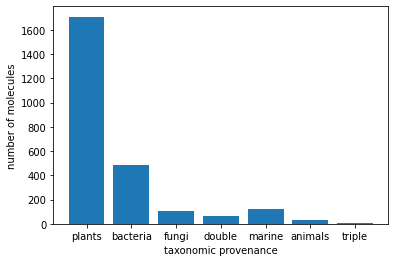

In [30]:
plt.bar(cnt.keys(),cnt.values())
plt.xlabel('taxonomic provenance')
plt.ylabel('number of molecules')

**Venn-Diagram: with marine**

In [31]:
taxonomy_Single = [list(tax) for tax in df_NP.taxonomy if 'double' not in tax and 'triple' not in tax]

In [32]:
taxonomy_All = taxonomy_Single + taxonomy_Double + taxonomy_Triple

In [33]:
plants = set()
bacteria = set()
animals = set()
marine = set()
fungi = set()

In [34]:
for tax_list in taxonomy_All:
    if "plants" in tax_list:
        for tax in tax_list:
            plants.add(tax.index)
    if "bacteria" in tax_list:
        for tax in tax_list:
            bacteria.add(tax.index)
    if "animals" in tax_list:
        for tax in tax_list:
            animals.add(tax.index)
    if "marine" in tax_list:
        for tax in tax_list:
            marine.add(tax.index)
    if "fungi" in tax_list:
        for tax in tax_list:
            fungi.add(tax.index)

/Users/jonas/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/venn/_backwards_compatibility.py:16: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "`get_labels()` is retained for backwards compatibility; " +
/Users/jonas/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


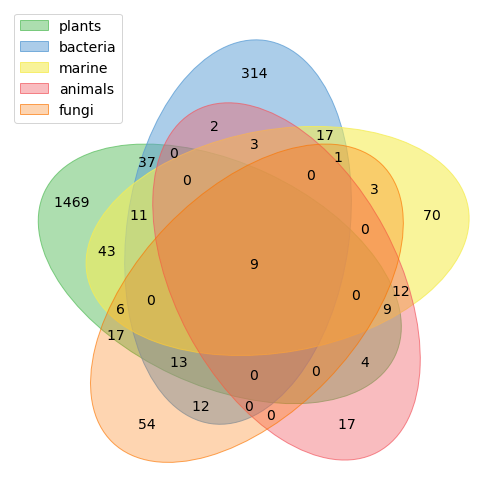

In [35]:
labels = venn.get_labels([plants,bacteria,marine,animals,fungi])
fig, ax = venn.venn5(labels,names=['plants','bacteria','marine','animals','fungi'])

**remove marine entry and create new venn-diagram**

In [36]:
counter = 0
for tax_set in df_NP.taxonomy:
    if len(tax_set) > 1 and "marine" in tax_set:
        tax_set.remove("marine")
        df_NP.taxonomy[counter] = tax_set
    elif len(tax_set) == 1 and "marine" in tax_set:
        df_NP.taxonomy[counter] = {"no"}
    counter += 1

In [37]:
taxonomy_Single = [list(tax) for tax in df_NP.taxonomy if 'double' not in tax and 'triple' not in tax]

In [38]:
taxonomy_All = taxonomy_Single + taxonomy_Double + taxonomy_Triple

In [39]:
plants = set()
bacteria = set()
animals = set()
fungi = set()

In [40]:
for tax_list in taxonomy_All:
    if "plants" in tax_list:
        for tax in tax_list:
            plants.add(tax.index)
    if "bacteria" in tax_list:
        for tax in tax_list:
            bacteria.add(tax.index)
    if "animals" in tax_list:
        for tax in tax_list:
            animals.add(tax.index)
    if "fungi" in tax_list:
        for tax in tax_list:
            fungi.add(tax.index)

/Users/jonas/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


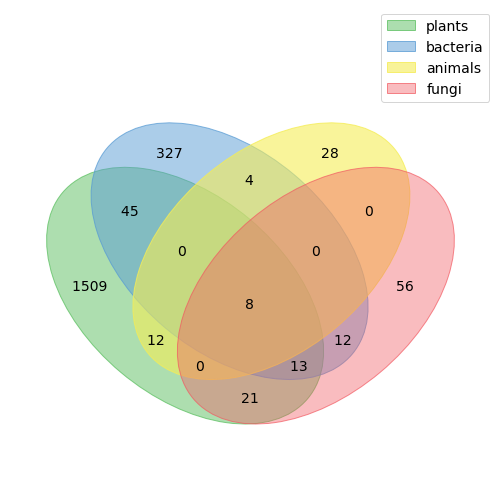

In [41]:
labels = venn.get_labels([plants,bacteria,animals,fungi])
fig, ax = venn.venn4(labels,names=['plants','bacteria','animals','fungi'])

**seperate aglycons with at least two different entries in taxonomy**


In [42]:
index_Unique_Tax = [ind for ind, tax_list in enumerate(df_NP.taxonomy) if len(tax_list) == 1]

In [43]:
df_Without_Double = df_NP.iloc[index_Unique_Tax[:]]

In [44]:
#df_Without_Double

**check for 'double' or 'triple' entries in taxonomy**

In [45]:
index_double_or_triple = [ind for ind, tax_list in enumerate(df_Without_Double.taxonomy) if 'double' not in tax_list or 'triple' not in tax_list]

In [46]:
df_Without_Double_or_Triple = df_Without_Double.iloc[index_double_or_triple[:]]

In [47]:
#df_Without_Double_or_Triple

**Fingerprints**

In [48]:
mol_From_Smiles = []
index_Mol_Explicit_Valence = []
index_Mol_Implicit_Valence = []
index = 0
for smiles in df_Without_Double_or_Triple.deglycosilated_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol == None:
        index_Mol_Explicit_Valence.append(index)
    else:
        mol_From_Smiles.append(mol)
        index_Mol_Implicit_Valence.append(index)
    index += 1    

RDKit ERROR: [09:38:36] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [09:38:36] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [09:38:37] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [09:38:37] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:38:37] Explicit valence for at

In [49]:
#print(index_Mol_Explicit_Valence)

In [50]:
df_Without_Explicit_Valence = df_Without_Double_or_Triple.iloc[index_Mol_Implicit_Valence[:]]

In [51]:
df_Without_Explicit_Valence = df_Without_Explicit_Valence.reset_index()

In [52]:
#df_Without_Explicit_Valence

In [53]:
fps = [AllChem.GetMorganFingerprint(mol,2,useFeatures=True) for mol in mol_From_Smiles]

create combinations of deglycosilated_smiles for indexing

In [54]:
aglycon_formula_for_indexing = list(df_Without_Explicit_Valence.deglycosilated_smiles)

In [55]:
aglycon_formulas = [aglycon_pair for aglycon_pair in itertools.combinations(aglycon_formula_for_indexing, 2)]

In [56]:
print(len(aglycon_formulas))

221645985


**Tanimoto Index between two different aglycons**

In [57]:
aglycon_pairs = itertools.combinations(fps, 2)

In [58]:
aglycon1_095 = []
aglycon2_095 = []
tanimoto_095 = []
aglycon1_090 = []
aglycon2_090 = []
tanimoto_090 = []
aglycon1_080 = []
aglycon2_080 = []
tanimoto_080 = []
counter = 0
for pair in aglycon_pairs:
    fingerprint = DataStructs.TanimotoSimilarity(pair[0],pair[1])
    if fingerprint >= 0.95:
        aglycon1_095.append(aglycon_formulas[counter][0])
        aglycon2_095.append(aglycon_formulas[counter][1])
        tanimoto_095.append(fingerprint)
        aglycon1_090.append(aglycon_formulas[counter][0])
        aglycon2_090.append(aglycon_formulas[counter][1])
        tanimoto_090.append(fingerprint)
        aglycon1_080.append(aglycon_formulas[counter][0])
        aglycon2_080.append(aglycon_formulas[counter][1])
        tanimoto_080.append(fingerprint)
    elif fingerprint >= 0.9:
        aglycon1_090.append(aglycon_formulas[counter][0])
        aglycon2_090.append(aglycon_formulas[counter][1])
        tanimoto_090.append(fingerprint)
        aglycon1_080.append(aglycon_formulas[counter][0])
        aglycon2_080.append(aglycon_formulas[counter][1])
        tanimoto_080.append(fingerprint)
    elif fingerprint >= 0.8:
        aglycon1_080.append(aglycon_formulas[counter][0])
        aglycon2_080.append(aglycon_formulas[counter][1])
        tanimoto_080.append(fingerprint)
    counter += 1

In [59]:
print(counter)

221645985


In [60]:
df_comparison_095 = pd.DataFrame({
    "aglycon1": aglycon1_095,
    "aglycon2": aglycon2_095,
    "tanimoto_index": tanimoto_095
})

In [61]:
df_comparison_095

,aglycon1,aglycon2,tanimoto_index
0,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,0.957627
1,OC(C)(C)C1OC(CCC(=CCCC=C(C)CCC2OC(CCC2(O)C)C(O...,OC(C)(C)C1OC(CC(=CCCC=C(C)CCCC2OC(CCC2(O)C)C(O...,0.959184
2,O=S(=O)([O-])OCC(C)C(C=CC(C)C1CC(O)C2C3(O)CC(O...,O=S(=O)([O-])OCC(C=CC(C)C1CC(O)C2C3(O)CC(O)C4C...,0.960396
3,O=C(OC1C(OC(=O)C)C2(CO)C(O)C(O)C3(C(=CCC4C5(C)...,O=C(OC1C(OC(=O)CC)C(C)(C)CC2C3=CCC4C5(C)CCC(O)...,0.956522
4,O=C1OCCC2=CC=C(OC3=CC(=CC=C3O)CCOC(=O)CC4C1=CO...,O=C1OCCC2=CC=C(O)C(OC3=CC=C(C=C3)CCOC(=O)CC4C1...,1.000000
...,...,...,...
3350,O=C(NC(CO)C(O)C(O)CC=CCCCCCCCCCCC)C(O)CCCCCCCC...,O=C(NC(CO)C(O)C(O)CC=CCCCCCCCCCCC)C(O)CCCCCCCC...,0.978571
3351,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCCC)COP(=O)(O)OC...,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,1.000000
3352,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCCC)COP(=O)(O)OC...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500
3353,O=C(O)C1=CC(OC=2C=C3C(=O)OC4C5OC(=O)C6=CC(O)=C...,O=C(O)C1=CC(O)=C(O)C(O)=C1OC=2C=C3C(=O)OC4C5OC...,0.963636


In [62]:
df_comparison_090 = pd.DataFrame({
    "aglycon1": aglycon1_090,
    "aglycon2": aglycon2_090,
    "tanimoto_index": tanimoto_090
})

In [63]:
df_comparison_090

,aglycon1,aglycon2,tanimoto_index
0,O=C1C=C(OC2=C1C(O)=CC(O)=C2C=3C(O)=CC(O)=C4C(=...,O=C1C=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(O)=C(C3)C4...,0.931034
1,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,0.957627
2,O=C1OC(CC)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,O=C1OC(C)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,0.932432
3,OC(C)(C)C1OC(CCC(=CCCC=C(C)CCC2OC(CCC2(O)C)C(O...,OC(C)(C)C1OC(CC(=CCCC=C(C)CCCC2OC(CCC2(O)C)C(O...,0.959184
4,O=S(=O)([O-])OCC(C)C(C=CC(C)C1CC(O)C2C3(O)CC(O...,O=S(=O)([O-])OCC(C=CC(C)C1CC(O)C2C3(O)CC(O)C4C...,0.960396
...,...,...,...
16981,O=C(NC(CO)C(O)C(O)CC=CCCCCCCCCCCC)C(O)CCCCCCCC...,O=C(NC(CO)C(O)C(O)CCCCCCCCCCCCCC)C(O)CCCCCCCCC...,0.923611
16982,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500
16983,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCCC)COP(=O)(O)OC...,0.930233
16984,O=C(NC(CO)C(O)C(O)CCCCC=CCC=CCCCCC)C(O)CCCCCCC...,O=C(NC(CO)C(O)C(O)CCCCCCCCCCCCCC)C(O)C(O)CCCCC...,0.910959


In [64]:
df_comparison_080 = pd.DataFrame({
    "aglycon1": aglycon1_080,
    "aglycon2": aglycon2_080,
    "tanimoto_index": tanimoto_080
})

In [65]:
df_comparison_080

,aglycon1,aglycon2,tanimoto_index
0,O=C1C=C(OC2=C1C(O)=CC(O)=C2C=3C(O)=CC(O)=C4C(=...,O=C1C=C(OC2=C1C(O)=CC(O)=C2C=3C(O)=CC(OC)=C4C(...,0.876033
1,O=C1C=C(OC2=C1C(O)=CC(O)=C2C=3C(O)=CC(O)=C4C(=...,O=C1C=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(O)=C(C3)C4...,0.931034
2,O=C1C=C(OC2=C1C(O)=CC(O)=C2C=3C(O)=CC(O)=C4C(=...,O=C1C=C(OC=2C1=C(O)C=C(O)C2CC=3C(O)=CC(O)=C4C(...,0.845528
3,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,0.957627
4,O=C1OC(CC)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,O=C1OC(C)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C)CC1,0.810127
...,...,...,...
101847,O=C(O)C12CCC(C)(CO)CC2C3=CCC4C(C)(CCC5C(C)(CO)...,O=C(O)C12CCC(C)(CO)CC2C3=CCC4C(C)(CCC5C(C)(C(O...,0.832461
101848,OC1CC2C3(C)CCC(O)C(C)(C)C3CCC2(C)C4(C)CC(O)C(C...,OC(CCC=C(C)C)C1CCC2(C)C1C(O)CC3C4(C)CCC(O)C(C)...,0.852632
101849,OC1CC2C3(C)CCC(O)C(C)(C)C3CCC2(C)C4(C)CC(O)C(C...,O=CC12CCC(O)C(C)(C)C2CCC3(C)C1CC(O)C4C(CCC43C)...,0.803922
101850,OC(CCC=C(C)C)C1CCC2(C)C1C(O)CC3C4(C)CCC(O)C(C)...,O=CC12CCC(O)C(C)(C)C2CCC3(C)C1CC(O)C4C(CCC43C)...,0.800000


**merging dataframe and taxonomies**

In [66]:
df_aglycon_taxes_1 = pd.DataFrame({
    "aglycon1": df_Without_Double.deglycosilated_smiles,
    "taxonomy1": df_Without_Double.taxonomy,
})

In [67]:
df_aglycon_taxes_2 = pd.DataFrame({
    "aglycon2": df_Without_Double.deglycosilated_smiles,
    "taxonomy2": df_Without_Double.taxonomy,
})

*df_comparison_095*

In [68]:
df_comparison_095 = pd.merge(df_comparison_095, df_aglycon_taxes_1, how="left", on="aglycon1")

In [69]:
df_comparison_095 = pd.merge(df_comparison_095, df_aglycon_taxes_2, how="left", on="aglycon2")

In [70]:
df_comparison_095

,aglycon1,aglycon2,tanimoto_index,taxonomy1,taxonomy2
0,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,0.957627,{no},{no}
1,OC(C)(C)C1OC(CCC(=CCCC=C(C)CCC2OC(CCC2(O)C)C(O...,OC(C)(C)C1OC(CC(=CCCC=C(C)CCCC2OC(CCC2(O)C)C(O...,0.959184,{no},{no}
2,O=S(=O)([O-])OCC(C)C(C=CC(C)C1CC(O)C2C3(O)CC(O...,O=S(=O)([O-])OCC(C=CC(C)C1CC(O)C2C3(O)CC(O)C4C...,0.960396,{no},{no}
3,O=C(OC1C(OC(=O)C)C2(CO)C(O)C(O)C3(C(=CCC4C5(C)...,O=C(OC1C(OC(=O)CC)C(C)(C)CC2C3=CCC4C5(C)CCC(O)...,0.956522,{no},{no}
4,O=C1OCCC2=CC=C(OC3=CC(=CC=C3O)CCOC(=O)CC4C1=CO...,O=C1OCCC2=CC=C(O)C(OC3=CC=C(C=C3)CCOC(=O)CC4C1...,1.000000,{no},{no}
...,...,...,...,...,...
3350,O=C(NC(CO)C(O)C(O)CC=CCCCCCCCCCCC)C(O)CCCCCCCC...,O=C(NC(CO)C(O)C(O)CC=CCCCCCCCCCCC)C(O)CCCCCCCC...,0.978571,{no},{no}
3351,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCCC)COP(=O)(O)OC...,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,1.000000,{no},{no}
3352,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCCC)COP(=O)(O)OC...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500,{no},{no}
3353,O=C(O)C1=CC(OC=2C=C3C(=O)OC4C5OC(=O)C6=CC(O)=C...,O=C(O)C1=CC(O)=C(O)C(O)=C1OC=2C=C3C(=O)OC4C5OC...,0.963636,{no},{no}


*change tax-sets to values from 1 to 5*

In [71]:
tax1_to_value_095 = df_comparison_095.taxonomy1.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [72]:
tax2_to_value_095 = df_comparison_095.taxonomy2.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [73]:
df_comparison_095["tax1_as_value"] = tax1_to_value_095

In [74]:
df_comparison_095["tax2_as_value"] = tax2_to_value_095

In [75]:
df_comparison_095.to_csv("fingerprint_comparison095.tsv",sep="\t")

*df_comparison_090*

In [76]:
df_comparison_090 = pd.merge(df_comparison_090, df_aglycon_taxes_1, how="left", on="aglycon1")

In [77]:
df_comparison_090 = pd.merge(df_comparison_090, df_aglycon_taxes_2, how="left", on="aglycon2")

In [78]:
df_comparison_090

,aglycon1,aglycon2,tanimoto_index,taxonomy1,taxonomy2
0,O=C1C=C(OC2=C1C(O)=CC(O)=C2C=3C(O)=CC(O)=C4C(=...,O=C1C=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(O)=C(C3)C4...,0.931034,{no},{no}
1,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,O=C(O)C1C(O)CCCCC(O)CCCCCCC(=O)OC(CC=CC=CC=CC=...,0.957627,{no},{no}
2,O=C1OC(CC)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,O=C1OC(C)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,0.932432,{no},{bacteria}
3,OC(C)(C)C1OC(CCC(=CCCC=C(C)CCC2OC(CCC2(O)C)C(O...,OC(C)(C)C1OC(CC(=CCCC=C(C)CCCC2OC(CCC2(O)C)C(O...,0.959184,{no},{no}
4,O=S(=O)([O-])OCC(C)C(C=CC(C)C1CC(O)C2C3(O)CC(O...,O=S(=O)([O-])OCC(C=CC(C)C1CC(O)C2C3(O)CC(O)C4C...,0.960396,{no},{no}
...,...,...,...,...,...
16981,O=C(NC(CO)C(O)C(O)CC=CCCCCCCCCCCC)C(O)CCCCCCCC...,O=C(NC(CO)C(O)C(O)CCCCCCCCCCCCCC)C(O)CCCCCCCCC...,0.923611,{no},{no}
16982,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500,{no},{no}
16983,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCCC)COP(=O)(O)OC...,0.930233,{no},{no}
16984,O=C(NC(CO)C(O)C(O)CCCCC=CCC=CCCCCC)C(O)CCCCCCC...,O=C(NC(CO)C(O)C(O)CCCCCCCCCCCCCC)C(O)C(O)CCCCC...,0.910959,{no},{no}


*change tax-sets to values from 1 to 5*

In [79]:
tax1_to_value_090 = df_comparison_090.taxonomy1.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [80]:
tax2_to_value_090 = df_comparison_090.taxonomy2.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [81]:
df_comparison_090["tax1_as_value"] = tax1_to_value_090

In [82]:
df_comparison_090["tax2_as_value"] = tax2_to_value_090

In [83]:
df_comparison_090.to_csv("fingerprint_comparison090.tsv",sep="\t")

*df_comparison_080*

In [84]:
df_comparison_080 = pd.merge(df_comparison_080, df_aglycon_taxes_1, how="left", on="aglycon1")

In [85]:
df_comparison_080 = pd.merge(df_comparison_080, df_aglycon_taxes_2, how="left", on="aglycon2")

*change tax-sets to values from 1 to 5*

In [86]:
tax1_to_value_080 = df_comparison_080.taxonomy1.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [87]:
tax2_to_value_080 = df_comparison_080.taxonomy2.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [88]:
df_comparison_080["tax1_as_value"] = tax1_to_value_080

In [89]:
df_comparison_080["tax2_as_value"] = tax2_to_value_080

In [90]:
df_comparison_080.to_csv("fingerprint_comparison080.tsv",sep="\t")